# Yankees - Extended Feature Selection
* StelllarAlgo Data Science
* Ryan Kazmerik & Nakisa Rad
* Jan 12, 2022

## Hypothesis
Two very important components of a machine learning model are feature selection and feature engineering. Our idea is that adding some more features to the StellarAlgo retention model could improve performance of the model. This notebook will test the standard StellarAlgo retention model features.

## Experiment
This section details our experiment including querying data, data transformations, feature selection and modelling.

In [1]:
import getpass
import pyodbc
import pandas as pd
import warnings
import matplotlib.pyplot as plt

from pycaret.classification import *

warnings.filterwarnings('ignore')

### Let's connect to MSSQL and run a stored proc to get our dataset:

In [2]:
# connect to SQL Server.
SERVER = '52.44.171.130' 
DATABASE = 'datascience' 
USERNAME = 'nrad' 
PASSWORD = 'ThisIsQA123'
CNXN = pyodbc.connect('DRIVER={ODBC Driver 17 for SQL Server};SERVER='+SERVER+';DATABASE='+DATABASE+';UID='+USERNAME+';PWD='+ PASSWORD)

In [3]:
lkupclientid = 53 # Yankees

cursor = CNXN.cursor()

storedProc = (
    f"""Exec [stlrYankees].[ds].[getPropensityEventScoring] {lkupclientid}"""
)

df = pd.read_sql(storedProc, CNXN)

# apply some data transformations
df["year"] = pd.to_numeric(df["year"]) 

CNXN.commit()
cursor.close()

df.shape

(1162194, 43)

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1162194 entries, 0 to 1162193
Data columns (total 43 columns):
 #   Column                Non-Null Count    Dtype  
---  ------                --------------    -----  
 0   lkupClientId          1162194 non-null  int64  
 1   dimCustomerMasterId   1162194 non-null  int64  
 2   dimEventId            1162194 non-null  int64  
 3   inMarket              1162194 non-null  bool   
 4   customerNumber        1162194 non-null  object 
 5   year                  1162194 non-null  int64  
 6   productGrouping       1162194 non-null  object 
 7   totalSpent            1162192 non-null  float64
 8   recentDate            1162194 non-null  object 
 9   attendancePercent     1162194 non-null  float64
 10  renewedBeforeDays     1162194 non-null  int64  
 11  isBuyer               1162194 non-null  object 
 12  source_tenure         1162194 non-null  int64  
 13  tenure                1162194 non-null  int64  
 14  distToVenue           1162194 non-

### We should specify the features used in our model:

In [5]:
# choose the features for the stellar base retention model
features = ["dimCustomerMasterId",
    "inMarket",
        "totalSpent",
        "attendancePercent",
        "source_tenure",
        "tenure",
        "distToVenue",
        "totalGames",
        "recency",
        "click_link",
        "open_email",
        "send_email",
        "isNextGameBuyer",
        "year"
]

# copy your main dataframe
df_dataset = df

# choose the features & train year & test year
df_dataset = df_dataset[features]
df_dataset["year"] = pd.to_numeric(df_dataset["year"])
df_dataset = df_dataset.loc[df_dataset["year"] <= 2019]

df_train = df_dataset.sample(frac=0.85, random_state=786)
df_eval = df_dataset.drop(df_train.index)

df_train.reset_index(drop=True, inplace=True)
df_eval.reset_index(drop=True, inplace=True)

# print out the number of records for training and eval
print('Data for Modeling: ' + str(df_train.shape))
print('Unseen Data For Predictions: ' + str(df_eval.shape), end="\n\n")

Data for Modeling: (816683, 14)
Unseen Data For Predictions: (144120, 14)



### Now we can model the data using a binary classification prediction for the isnextyear_buyer field to see how likely a customer is to re-purchase.

In [9]:
setup(
    data= df_train, 
    target="isNextGameBuyer", 
    train_size = 0.80,
    data_split_shuffle=True,
    ignore_features=["dimCustomerMasterId","year"],
    silent=True,
    verbose=False,
    numeric_features=["inMarket",
        "totalSpent",
        "attendancePercent",
        "source_tenure",
        "tenure",
        "distToVenue",
        "totalGames",
        "recency",
        "click_link",
        "open_email",
        "send_email"
    ]
);

In [10]:
model_matrix = compare_models(
    fold=10,
    include=["lr", "xgboost"]
)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
xgboost,Extreme Gradient Boosting,0.9699,0.9475,0.3946,0.6943,0.5031,0.4887,0.5097,14.6570
lr,Logistic Regression,0.9628,0.8494,0.1090,0.6048,0.1846,0.1749,0.2459,13.7570


In [11]:
best_model = create_model(model_matrix)
final_model = finalize_model(best_model)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.9682,0.9437,0.3777,0.6525,0.4784,0.4632,0.4817
1,0.9704,0.9475,0.3880,0.7164,0.5033,0.4895,0.5141
2,0.9697,0.9464,0.3820,0.6968,0.4935,0.4792,0.5024
3,0.9693,0.9461,0.3955,0.6745,0.4986,0.4839,0.5023
4,0.9697,0.9468,0.3856,0.6957,0.4962,0.4819,0.5043
5,0.9702,0.9485,0.3979,0.7028,0.5081,0.4939,0.5153
6,0.9705,0.9511,0.4150,0.7001,0.5211,0.5069,0.5255
7,0.9698,0.9475,0.4014,0.6879,0.5070,0.4925,0.5116
8,0.9704,0.9474,0.4062,0.7042,0.5152,0.5011,0.5214
9,0.9705,0.9498,0.3963,0.7119,0.5092,0.4952,0.5179


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Library/Frameworks/Py

### Let's load in our 2021 season data and get retention scores using the model:

In [12]:
df_inference = df.loc[df["year"] >= 2021]
df_inference = df_inference.fillna(0)
df_inference.shape

(201391, 43)

In [13]:
new_predictions = predict_model(final_model, data=df_inference, raw_score=True)
new_predictions.head()

,lkupClientId,dimCustomerMasterId,dimEventId,inMarket,customerNumber,year,productGrouping,totalSpent,recentDate,attendancePercent,...,outbound_email,outbound_phonecall,phonecall,text,unknown,credits_after_refund,isNextGameBuyer,Label,Score_0,Score_1
960803,53,29,1208,False,233585,2021,Other,326.0,2021-09-06,1.000,...,0,0,0,0,0,0.0,0,0,0.9859,0.0141
960804,53,33,1342,True,7332655,2021,Other,558.0,2021-08-16,1.000,...,0,0,0,0,0,0.0,0,0,0.9955,0.0045
960805,53,55,1337,True,15140559,2021,Other,160.0,2021-05-31,0.875,...,0,0,0,0,0,0.0,0,0,0.8931,0.1069
960806,53,55,1339,True,15140559,2021,Other,440.0,2021-06-05,0.750,...,0,0,0,0,0,0.0,0,0,0.9169,0.0831
960807,53,58,753,True,7263645,2021,Other,132.0,2021-04-01,0.750,...,0,0,0,0,0,0.0,0,0,0.9647,0.0353


In [14]:
new_predictions["Label"].value_counts()

0    199216
1      2175
Name: Label, dtype: int64

In [15]:
#new_predictions = new_predictions.loc[new_predictions["productGrouping"] == "Full Season"]

array([[<AxesSubplot:title={'center':'Score_1'}>]], dtype=object)

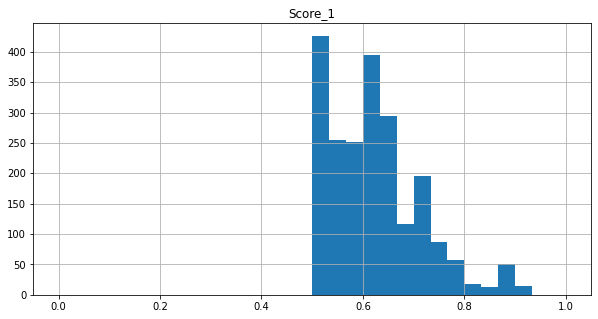

In [16]:
new_predictions[new_predictions["Label"]==1][["Score_1"]].hist(bins=30, figsize=(10,5), range=[0,1])

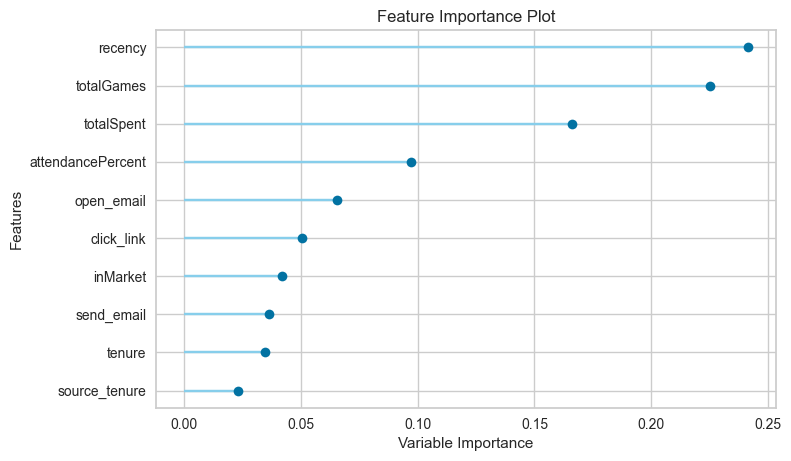

In [17]:
plot_model(best_model, plot='feature')

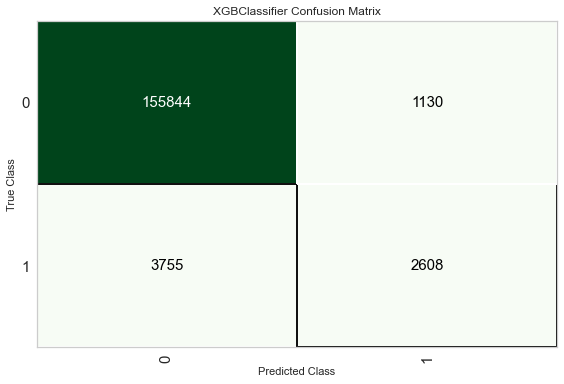

In [18]:
plot_model(best_model, plot='confusion_matrix')

## Observations
Here you can document some ideas on the results from above

## Conclusions
Here you can talk about next steps, did the experiment work? If yes, what to do next? If no, why?